In [1]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

## Dealing with GeoJson

In [2]:
geo_df = gpd.read_file("data/chicago_boundaries.geojson")
geo_df.sort_values("pri_neigh").head(10)

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
52,Albany Park,"NORTH PARK,ALBANY PARK",53542230.819,39339.016439,(POLYGON ((-87.70403771340104 41.9735515838182...
42,Andersonville,ANDERSONVILLE,9584592.89906,12534.092625,(POLYGON ((-87.66114249176968 41.9763032707800...
78,Archer Heights,"ARCHER HEIGHTS,WEST ELSDON",55922505.7212,31880.02103,(POLYGON ((-87.71436934735939 41.8260405636423...
8,Armour Square,"ARMOUR SQUARE,CHINATOWN",17141468.6356,24359.189625,(POLYGON ((-87.62920071904188 41.8471270613852...
21,Ashburn,ASHBURN,135460337.208,54818.154632,(POLYGON ((-87.71254775561138 41.7573373338274...
70,Auburn Gresham,AUBURN GRESHAM,105065353.602,46757.721716,(POLYGON ((-87.63990005778429 41.7561457832194...
94,Austin,AUSTIN,170037750.826,55473.345911,(POLYGON ((-87.75619515209075 41.9154695475812...
9,Avalon Park,"AVALON PARK,CALUMET HEIGHTS",34852737.7366,27630.822534,(POLYGON ((-87.58565529833413 41.7515019433031...
12,Avondale,"IRVING PARK,AVONDALE",55290595.482,34261.933404,(POLYGON ((-87.68798678784357 41.9361039411813...
93,Belmont Cragin,"BELMONT CRAGIN,HERMOSA",109099407.211,43311.706886,(POLYGON ((-87.74142999502229 41.9169848303604...


In [3]:
neighs = geo_df.pri_neigh.tolist()

In [11]:
def plot_map(geo_df, data=None, column_name=None, map_name="map.html"):
    m = folium.Map(location=[41.8755616, -87.6244212], tiles='Mapbox Bright', zoom_start=11) ## This location is Chicago
    
    if data is None:
        folium.GeoJson(
            geo_df,
            name='geojson'
        ).add_to(m)
    else:
        bins = list(data.quantile(np.linspace(0, 1, 15))) ## to use bins, gotta check fill_color
        folium.Choropleth(
            geo_data=geo_df,
            name='choropleth',
            data=data,
            columns=["pri_neigh", column_name],
            key_on='feature.properties.pri_neigh',
            fill_color='YlGnBu',
            fill_opacity=0.7,
            line_opacity=0.2
            #bins=bins
        ).add_to(m)
        
    m.save(map_name)

In [12]:
plot_map(geo_df)

RuntimeError: b'no arguments in initialization list'

## Dealing with Food Inspections

In [13]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections = inspections.dropna(subset=["Latitude", "Longitude"]) ## we drop if we do not know the location
inspections["date"] = pd.to_datetime(inspections["Inspection Date"])
inspections.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location', 'date'],
      dtype='object')

In [14]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,date
0,2201126,NEW CHINA WOK,NEW CHINA WOK,2621123.0,Restaurant,Risk 1 (High),752 W GARFIELD BLVD,CHICAGO,IL,60609.0,2018-08-17T00:00:00,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.794417,-87.644816,"{'longitude': '-87.64481608216055', 'needs_rec...",2018-08-17
1,2201124,FANNIE SCHMOE'S BAKERY,FANNIE'S CAFE,2432423.0,Restaurant,Risk 1 (High),5040-5044 W Montrose AVE,CHICAGO,IL,60641.0,2018-08-17T00:00:00,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.960745,-87.754004,"{'longitude': '-87.75400366103027', 'needs_rec...",2018-08-17
2,2201123,"NEWPORT ACADEMY, INC.",NEWPORT CHILDREN'S ACADEMY,2458128.0,Children's Services Facility,Risk 1 (High),1819-1825 W NEWPORT AVE,CHICAGO,IL,60657.0,2018-08-17T00:00:00,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.944061,-87.674704,"{'longitude': '-87.67470356794354', 'needs_rec...",2018-08-17
3,2201122,YEFSEIS,YEFSEIS,2617529.0,NaN,Risk 1 (High),3344 N HALSTED ST,CHICAGO,IL,60657.0,2018-08-17T00:00:00,License,Not Ready,NaN,41.943130,-87.649512,"{'longitude': '-87.64951168839137', 'needs_rec...",2018-08-17
4,2201116,"EASTSIDE SHARKS, INC.",SHARKS,1545884.0,Restaurant,Risk 2 (Medium),100 E 79TH ST,CHICAGO,IL,60619.0,2018-08-17T00:00:00,Complaint,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.751118,-87.621307,"{'longitude': '-87.62130733246569', 'needs_rec...",2018-08-17


In [15]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'pri_neigh']

## key: key that will be used to join
def assign_neigh(geo_df, data, key, latitude="Latitude", longitude="Longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data[[key, latitude, longitude]], 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh.pri_neigh)]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found.pri_neigh = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh.pri_neigh)])))
    
    return points_to_neigh[[key, "pri_neigh", "sec_neigh"]]
    

In [16]:
inspection_location = assign_neigh(geo_df=geo_df, data=inspections, key="Inspection ID", verbose=True)

There are 2416 points without an exact neighborhood


C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


There are 0 points without an exact neighborhood


In [ ]:
inspections = inspections.merge(inspection_location, on="Inspection ID")

In [ ]:
neigh_inspections = inspections.groupby("pri_neigh").count()["Inspection ID"]
plot_map(geo_df, data=neigh_inspections, column_name="Inspection ID", map_name="map.html")

In [ ]:
inspections.Results.unique()

In [ ]:
def get_percentage_results(data, neigh_key="pri_neigh", results="Results", key="Inspection ID", result_type=None):
    neigh_inspections = inspections.groupby(neigh_key).count()[key]
    neigh_results = inspections.groupby([neigh_key, results]).count()[key]
    percentage_results = (neigh_results.div(neigh_inspections) * 100).reset_index()
    if result_type is None:
        return percentage_results
    else:
        return percentage_results[percentage_results.Results == result_type]

In [ ]:
percentage_fail = get_percentage_results(inspections, result_type="Fail")
percentage_fail

In [ ]:
plot_map(geo_df, data=percentage_fail, column_name="Inspection ID", map_name="map.html")

### Gotta analyze the different types of results. Risks can also be interesting. 
### Below the case of Subway

In [ ]:
def get_inspections_restaurant(inspections, restaurant):
    return inspections[inspections["DBA Name"].str.contains(restaurant)]

### Case for subway
inspections_subway = get_inspections_restaurant(inspections, "SUBWAY")
inspections_subway

In [ ]:
percentage_fail_subway = get_percentage_results(inspections, result_type="Fail")
percentage_fail_subway

In [ ]:
plot_map(geo_df, data=percentage_fail_subway, column_name="Inspection ID", map_name="map.html")
## There are a few areas with more fails and it seems like it is in the black part 

## Dealing with Income - for some reason geolocator is not working

In [ ]:
income_df = pd.read_csv("data/economic-info.csv")
income_df = income_df.merge(geo_df, left_on="COMMUNITY AREA NAME", right_on="pri_neigh")
income_df.head()

In [ ]:
len(income_df), len(geo_df) ## not same size, there are more in the map

In [ ]:
plot_map(geo_df, data=income_df, column_name="PER CAPITA INCOME ", map_name="map.html")

In [ ]:
missing_neighs = list(set(geo_df.pri_neigh) - set(income_df["pri_neigh"]))
missing_neighs[:5], len(missing_neighs)

In [ ]:
set(income_df["pri_neigh"]) - set(geo_df.pri_neigh)

In [ ]:
## lets find the nearest one and assign the same data
geolocator = Nominatim(user_agent="NKPDF", timeout=3)
neigh_point_dict = []
for neigh in missing_neighs:
    location = geolocator.geocode("{} Chicago".format(neigh))
    if location is not None: ## gotta fix this
        neigh_point_dict.append({"pri_neigh": neigh, "geometry": Point(location.longitude, location.latitude)})
missing_neighs_df = gpd.GeoDataFrame(neigh_point_dict, crs={'init': 'epsg:4326'})
missing_neighs_df.head()

####### THERE IS "RUSH & DIVISION" & another one WHICH IS NULL, GOTTA FIX
####### e.g. location = geolocator.geocode("Rush & Division, Chicago".format(neigh)) == None

In [ ]:
##pri_neigh is the one we use to plot (from geo_df), data_neigh is the one from income_df
tmp_income_df = gpd.GeoDataFrame(income_df.copy())
missing_neighs_df["data_neigh"] = missing_neighs_df.copy().geometry.apply(get_nearest_neigh, geo_df=tmp_income_df)\
                                    .rename(columns={"geometry": "data_neigh"})
missing_neighs_df.head()

In [ ]:
income_df_join = income_df.copy().rename(columns={"pri_neigh": "data_neigh"}).drop(columns="geometry")
missing_neighs_df = missing_neighs_df.merge(income_df_join, how="left", on="data_neigh")
missing_neighs_df.head()

In [ ]:
#save_missing_neighs = missing_neighs_df.copy()
missing_neighs_df = save_missing_neighs.copy()
missing_neighs_df.head()

In [ ]:
income_df = income_df.append(missing_neighs_df.drop(columns="data_neigh"), sort=False)
income_df.head()

In [ ]:
plot_map(geo_df, data=income_df, column_name="PER CAPITA INCOME ", map_name="map.html")

### This is far from perfect, there are two regions missing and an area that looks rich in the middle of poor neighbourhoods.

In [ ]:
park = geo_df[geo_df.pri_neigh == "North Park"]
park

In [ ]:
geo_df.geometry.distance(park.centroid.values[0]).nsmallest(3)

### Maybe do like above? Get the smallest and average them?

### Crime Inspection

In [17]:
crime_df = pd.read_csv('data\Crimes_2001-2019.csv')
crime_df.head(10)
len(crime_df)

C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


7001563

Since the dataset is 1.5gb and our Food inspection data are from 2010 and 2018 I exclude the crimes before 2010 and we can work with an easier DF.

In [18]:
crime_df = crime_df.loc[crime_df.Year>2009]
crime_df.head(10)
len(crime_df)

2925035

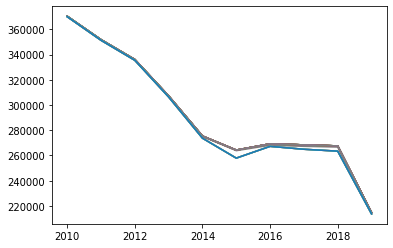

In [19]:
crime_per_year = crime_df.groupby('Year').count()
plt.plot(crime_per_year)

Is interesting to see that there is a drop of crimes in the city, we can verify if there is a drop also in the failed food inspections.

In [20]:
crime_df = crime_df.dropna(subset=["Latitude","Longitude"])
crime_df.head(10)
len(crime_df)

2903942

In [21]:
crime_df['Primary Type'].unique()

array(['SEX OFFENSE', 'OFFENSE INVOLVING CHILDREN', 'BATTERY', 'ASSAULT',
       'THEFT', 'STALKING', 'CRIMINAL DAMAGE', 'MOTOR VEHICLE THEFT',
       'OTHER OFFENSE', 'NARCOTICS', 'CRIM SEXUAL ASSAULT', 'ROBBERY',
       'INTERFERENCE WITH PUBLIC OFFICER', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'BURGLARY', 'WEAPONS VIOLATION',
       'PROSTITUTION', 'GAMBLING', 'ARSON', 'PUBLIC PEACE VIOLATION',
       'KIDNAPPING', 'INTIMIDATION', 'CONCEALED CARRY LICENSE VIOLATION',
       'LIQUOR LAW VIOLATION', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'OBSCENITY', 'HUMAN TRAFFICKING',
       'HOMICIDE', 'NON-CRIMINAL', 'NON - CRIMINAL',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

Some type of violation could be excluded for some resons:
- Liquor law violation is not an index of dangerous neughborhood
- Non-Criminal actions are used to code police calls that are not crimes
- Concealed carry license violation is usually found when a vehicle is in moving so we can not connect the place where is found to a neighborhood quartier

In [22]:
test = crime_df[crime_df["Primary Type"]=="NON-CRIMINAL"]
test.head(20)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
163989,11839206,JC446419,09/20/2019 12:00:00 PM,034XX W 63RD ST,1481,NON-CRIMINAL,CONCEALED CARRY LICENSE REVOCATION,POLICE FACILITY/VEH PARKING LOT,False,False,...,23.0,66.0,15,1154582.0,1862632.0,2019,09/27/2019 04:08:19 PM,41.778877,-87.708840,"(41.778877155, -87.708840106)"
279306,10132522,HY321435,06/29/2015 10:23:00 PM,044XX W 76TH ST,1481,NON-CRIMINAL,CONCEALED CARRY LICENSE REVOCATION,STREET,True,False,...,13.0,65.0,15,1148140.0,1853871.0,2015,08/17/2015 03:03:40 PM,41.754961,-87.732682,"(41.754961443, -87.732681619)"
294154,10157940,HY347539,07/08/2015 10:30:00 AM,016XX W CHICAGO AVE,5093,NON-CRIMINAL,LOST PASSPORT,STREET,False,False,...,1.0,24.0,26,1165158.0,1905410.0,2015,02/10/2018 03:50:01 PM,41.896047,-87.668854,"(41.896047034, -87.668854221)"
324114,10212100,HY398571,08/26/2015 05:45:00 PM,017XX S STATE ST,0585,NON-CRIMINAL,NOTIFICATION OF STALKING - NO CONTACT ORDER,POLICE FACILITY/VEH PARKING LOT,True,False,...,3.0,33.0,26,1176607.0,1891853.0,2015,02/10/2018 03:50:01 PM,41.858595,-87.627214,"(41.858594819, -87.627214427)"
324594,10213039,HY398172,08/26/2015 11:45:00 AM,0000X W TERMINAL ST,5093,NON-CRIMINAL,LOST PASSPORT,AIRPORT TERMINAL UPPER LEVEL - SECURE AREA,False,False,...,41.0,76.0,26,1101811.0,1934419.0,2015,02/10/2018 03:50:01 PM,41.976763,-87.900984,"(41.976762981, -87.900983721)"
362824,10277370,HY465290,10/16/2015 08:00:00 PM,100XX W OHARE ST,5093,NON-CRIMINAL,LOST PASSPORT,AIRCRAFT,False,False,...,41.0,76.0,26,1100658.0,1934241.0,2015,02/10/2018 03:50:01 PM,41.976290,-87.905227,"(41.976290414, -87.905227221)"
370565,10290745,HY478502,10/26/2015 04:00:00 PM,004XX W DIVERSEY PKWY,5093,NON-CRIMINAL,LOST PASSPORT,SIDEWALK,False,False,...,44.0,6.0,26,1172533.0,1918887.0,2015,02/10/2018 03:50:01 PM,41.932869,-87.641368,"(41.932868651, -87.641368196)"
374196,10296800,HY485235,09/30/2015 05:00:00 PM,008XX N MAPLEWOOD AVE,5093,NON-CRIMINAL,LOST PASSPORT,SIDEWALK,False,False,...,1.0,24.0,26,1159246.0,1905582.0,2015,02/10/2018 03:50:01 PM,41.896643,-87.690563,"(41.896642608, -87.690563055)"
391653,10325994,HY516457,11/26/2015 11:30:00 PM,001XX W HUBBARD ST,5093,NON-CRIMINAL,LOST PASSPORT,RESTAURANT,False,False,...,42.0,8.0,26,1175301.0,1903292.0,2015,02/10/2018 03:50:01 PM,41.890014,-87.631665,"(41.890013524, -87.631664996)"
398253,10336794,HY527983,10/26/2015 02:00:00 PM,006XX N STATE ST,5093,NON-CRIMINAL,LOST PASSPORT,OTHER,False,False,...,42.0,8.0,26,1176262.0,1904268.0,2015,02/10/2018 03:50:01 PM,41.892670,-87.628106,"(41.8926701, -87.628106353)"


In [23]:
crime_df = crime_df[~crime_df['Primary Type'].isin(['LIQUOR LAW VIOLATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)'])]
crime_df.head(10)
len(crime_df)

2899279

We pass from 7 milion to 2.9 milions of records